# Score Matching

This section is about learning a score function from data using a neural network.
We will not yet address the notion of sampling from the SBM, 
which is covered in the next section on [diffusion](./03-diffusion.ipynb). 

## Naive Score Matching

Constructing a loss function for score-matching is rather straight forward. The procedure was first described 
by [Aapo Hyvärinen in 2005](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf). 
Suppose $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$ is a neural network with parameters $\theta$. This network 
can be trained to match a score function by minimizing the mean squared error loss function

$$
    \mathcal{L}_\theta = \mathbb{E}_{p(\mathbf{x})} 
    \bigg[\big\lVert \mathbf{s}_\theta(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \big\rVert^2_2 \bigg] \, .
$$

This construction is naive because it assumes we have access to the ground truth score, $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. Naturally, there would be no need to train a neural network if we did. This is why [Hyvärinen (2005)](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf) derived an equivalent loss 
function which abstracts away the ground truth score. His work eventually led Yang Song to build the Sliced Score Matching (SSM) loss function ([Song et al. (2019)](https://arxiv.org/abs/1905.07088)) using the Hutchinson trace estimator to speed up the Hessian trace in Hyvärinen's loss function.

Instead of the SSM loss function, we will focus on the naive score matching approach to demonstrate some of its pitfalls &mdash; which the SSM also inherited. 
As it turns out, score matching is not straightforward even when given perfect information about the ground truth score.

We will build score-matching from scratch to showcase the internals of the score models package. The relevant stuff to score-matching that we do in this notebook is abstracted away in the package. You can find the routines in the [Getting Started](./00-Overview.md) page.

In [1]:
!pip install --quiet score_models colorcet SciencePlots tqdm # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### Score model with signature $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$

In [2]:
class SBM(nn.Module):
    def __init__(self, n, depth=2, width=100):
        super().__init__()
        self.n = n
        module_list = [nn.Linear(n, width)] # Input layer n -> width
        for i in range(depth):
            module_list.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, n) # Output layer width -> n
        self.layers = nn.ModuleList(module_list)
    
    def forward(self, x):
        for layer in self.layers:
            x = F.silu(layer(x))
        x = self.output_layer(x) # Output layer has no activation function
        return x

### Ground-truth score function


In [3]:
distribution = egg_box(4, mode_width=0.1, box_size=1)
# distribution = two_moons()
# distribution = swiss_roll()

def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

### Training the SBM

In [4]:
def naive_score_matching_loss(x, sbm):
    return ((score(x) - sbm(x))**2).flatten(1).sum(1).mean()

In [5]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = SBM(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    x = distribution.sample((B,))
    loss = naive_score_matching_loss(x, net)
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

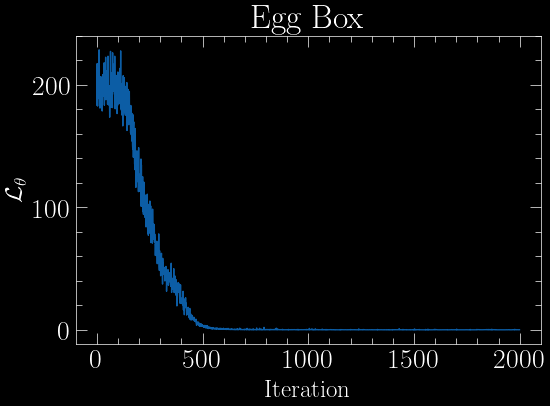

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title(r"Egg Box")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

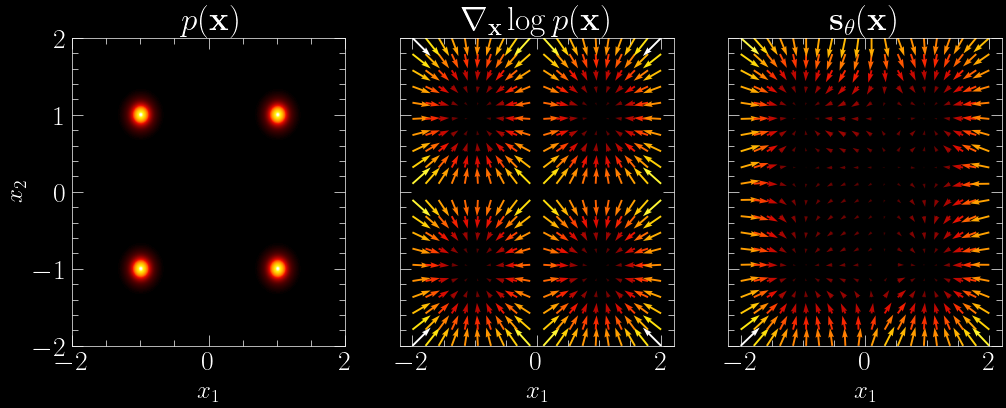

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

ax = axs[0]
plot_density(logp, ax=ax, extent=extent)
ax.set_title(r"$ p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$")

ax = axs[1]
plot_score(score, ax=ax, extent=extent)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$")

ax = axs[2]
plot_score(net, ax=ax, extent=extent)
ax.set_title(r"$\mathbf{s}_\theta(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");

Close to each mode, the score is very well approximated. 
But, in between the modes, the model is a rather poor approximation of the ground truth score even though the loss $\mathcal{L}_\theta$ is very close to zero &mdash; see the loss curve above. 

When we train the neural network, we do not uniformly sample the ambiant space $\mathbb{R}^n$. Rather, we sample from the distribution $p(\mathbf{x})$. 
It is almost impossible to sample a point in between the modes &mdash; which we chose to be well-separated. The loss function is blind there. 

To alleviate this problem, we can change the sampling distribution to something more uniform.
Although it might work for our toy example, we might worry about what happens in high-dimensional spaces &mdash; like images. 
The volume of a vector space scales exponentially with the dimensionality. 
And there is this thing called the manifold hypothesis, which claims &mdash; rightly &mdash; that data typically belongs to a manifold of dimensionality far smaller than the ambiant space in which we observe it. 
In other words, the probability of randomly choosing a valid sample from $p(\mathbf{x})$ in $\mathbb{R}^n$ is 
vanishingly small as $n$ increases &mdash; at least for interesting $p(\mathbf{x})$. 
If we want to approximate the score of $p(\mathbf{x})$, we better make sure our score is good near points of high-density. 

There are also good theoretical reasons to keep $p(\mathbf{x})$ in our sampling distribution. 
In fact, the loss $\mathcal{L}_\theta$ is a forward Fisher divergence, which is closely related to the Kullback-Leibler divergence. We will come back to this point later.

### Annealing the distribution

Our first attempt at improving score matching is to introduce an annealing procedure. Technically, this implementation of annealing assumes we have access to the ground truth score. But bear with me, we'll eventually define a procedure that works with data. Let's recall the Gibbs measure and use the (inverse) temperature parameter $\beta$ to describe a family of distributions related by the same energy function

$$
    p_\beta(\mathbf{x}) = \frac{1}{\mathcal{Z}}e^{- \beta E(\mathbf{x})}\, .
$$

When $\beta \rightarrow 0$, the exponential tend to one. Loosely speaking, $p_0(\mathbf{x})$ will describe a Uniform distribution

$$
    p_0(\mathbf{x}) = \mathcal{U}(\mathbb{R}^n)\, .
$$

When $\beta \rightarrow \infty$, the exponential becomes extremely sensitive to any non-zero energy values. 
In fact, $\beta \rightarrow \infty$ will describe a sum of Dirac deltas

$$
p_\infty(\mathbf{x}) = \sum_{j}\delta^{(n)}(\mathbf{x} - \boldsymbol{\mu}_j)\, .
$$ 

The sum runs over all point s.t. $E(\boldsymbol{\mu}_j) = 0$. For our exercice, we only need to consider the family 
$\beta \in [0, 1]$, where $\beta = 1$ corresponds to our target distribution. For our Gaussian mixture, the distribution has the form

$$
    p_\beta(\mathbf{x}) = \frac{1}{\mathcal{Z}}\sum_{i} w_i e^{-\beta E_i(\mathbf{x})}\, ,
$$

with the energy function

$$
    E_i(\mathbf{x}) = \frac{1}{2 \sigma^2} \lVert \mathbf{x} - \boldsymbol{\mu}_i \rVert^2 \, .
$$

Therefore, the temperature parameters has the effect of scaling the size of each mode

$$
    \sigma(\beta) = \frac{\sigma}{\sqrt{\beta}}\, .
$$

### Annealed score matching

Learning a family of distribution might seem like a more difficult task than what we set out to do initially. The point is that we'll be changing the sampling distribution accordingly so that the neural network can train on points from the ambiant space &mdash; in between the modes. We'll use the following loss function

$$
    \mathcal{L}_\theta = \mathbb{E}_{p(\beta)} \mathbb{E}_{p_\beta(\mathbf{x})}
        \bigg[ \lambda(\beta) \big\lVert 
            \mathbf{s}_\theta(\beta, \mathbf{x}) - \nabla_{\mathbf{x}} \log p_\beta(\mathbf{x}) 
         \big\rVert^2_2 \bigg]\, .
$$

We introduced a weight factor $\lambda(\beta)$ to control the importance of the different temperature. We will make the choice

$$
    \lambda(\beta) = \beta^{-1}\, ,
$$
anticipating the formal derivation of the loss function. We also choose $p(\beta)$ to be a log uniform distribution over the range $[10^{-3}, 1]$. The lower bound is to avoid the singularity as $\beta \rightarrow 0$. 
Also, to make the task easier for the neural network, we redefine the score to incorporate the temperature parameter

$$
    \mathbf{s}_\theta(\beta, \mathbf{x}) \equiv \sqrt{\beta} \boldsymbol{\epsilon}_\theta(\beta, \mathbf{x})\, .
$$

$\boldsymbol{\epsilon}_\theta: [0, 1] \times \mathbb{R}^n \rightarrow \mathbb{R}^n$ will be a neural network. Notice that we need to incorporate temperature parameter as input. We modify the architecture of the neural network accordingly in the implementation below.

In [8]:
def annealed_egg_box(beta): # p_{\beta}(\mathbf{x})
    mode_width = 0.1 / beta**(1/2)
    return egg_box(4, mode_width=mode_width, box_size=1)

def sample_annealed_egg_box(beta):
    return vmap(lambda beta: annealed_egg_box(beta).sample((1,)), randomness="different")(beta).view(-1, 2)

def annealed_logp(beta, x):
    return annealed_egg_box(beta).log_prob(x)

def annealed_score(beta, x):
    return vmap(grad(annealed_logp, argnums=1))(beta, x)


In [9]:
left_matmul = vmap(torch.matmul, in_dims=(None, 0))

class PositionalEncoding(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.W = nn.Parameter(torch.randn(width//2, 1))
    
    def forward(self, beta):
        beta = beta.view(-1, 1)
        beta = left_matmul(self.W, beta) * 2 * np.pi
        return torch.cat([torch.sin(beta), torch.cos(beta)], 1)

class Epsilon(nn.Module):
    def __init__(self, n, depth=2, width=100):
        super().__init__()
        self.n = n
        self.pe = PositionalEncoding(width) # Encode beta into a positional encoding 1 -> width
        self.input_layer = nn.Linear(2, width) # Input layer n -> width
        module_list = []
        for i in range(depth):
            module_list.append(nn.Linear(2*width, width))
        self.output_layer = nn.Linear(2*width, n) # Output layer width -> n
        self.layers = nn.ModuleList(module_list)
    
    def forward(self, beta, x):
        beta_features = self.pe(beta)
        x = F.silu(self.input_layer(x))
        x = torch.cat([x, beta_features], -1)
        for layer in self.layers:
            x = F.silu(layer(x))
            x = torch.cat([x, beta_features], -1)
        x = self.output_layer(x)
        return x

In [10]:
def annealed_score_matching_loss(beta, x, epsilon):
    s_theta = beta.view(-1, 1)**(1/2) * epsilon(beta, x)
    score = annealed_score(beta, x)
    return (beta.view(-1, 1)**(-1) * (score - s_theta)**2).flatten(1).sum(1).mean()

In [11]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = Epsilon(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    beta = 10**(- 3 * torch.rand(B))
    x = sample_annealed_egg_box(beta)
    loss = annealed_score_matching_loss(beta, x, net)
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

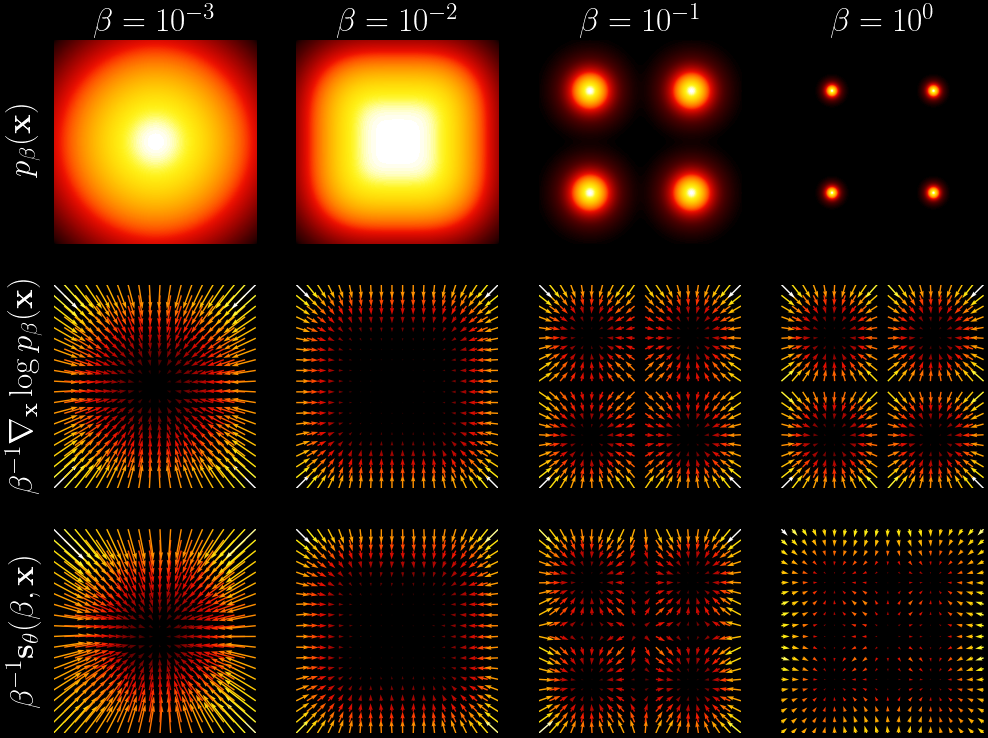

In [12]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
extent = (-2, 2, -2, 2)

for i in range(4):
    beta = [1e-3, 1e-2, 1e-1, 1.][i]
    ax = axs[0, i]
    plot_density(annealed_egg_box(beta).log_prob, ax=ax, extent=extent)
    ax.set_title(r"$\beta = 10^{%d}$" % np.log10(beta))
    ax.axis("off")

    ax = axs[1, i]
    score_fn = lambda x: annealed_score(torch.tensor([beta]).repeat(x.shape[0]), x)/beta
    plot_score(score_fn, ax=ax, extent=extent)
    ax.axis("off")

    ax = axs[2, i]
    score_fn = lambda x: net(torch.tensor([beta]).repeat(x.shape[0]), x)/beta**(1/2)
    plot_score(score_fn, ax=ax, extent=extent)
    ax.axis("off");
axs[0, 0].annotate(r"$p_{\beta}(\mathbf{x})$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[1, 0].annotate(r"$\beta^{-1}\nabla_{\mathbf{x}} \log p_{\beta}(\mathbf{x})$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[2, 0].annotate(r"$\beta^{-1}\mathbf{s}_\theta(\beta, \mathbf{x})$", (-0.15, 0.5),
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24);

Not so bad. The model is able to accurately capture the score for a wide range of values for $\beta$. It is also much more precise in regions of low density compared to our previous attempts. 

Unfortunately, the score at $\beta = 1$ is still not quite correct in regions of low density. As it turns out, we don't need to worry about this. But it's a good thing to keep in mind. It's rather tricky to get the score to be globally accurate at $\beta = 1$. In practice, there might be specific choices for the sampling distribution or the weight $\lambda(\beta)$ that alleviate this problem. We will not explore this here.

## Denoising Score-Matching (DSM)

Now, the interesting question is: how do we make this work when we don't have access to the target score function? To make this work, we need to construct a score matching procedure that do not make use of any knowledge about the actual distribution. This procedure was discovered by [Pascal Vincent in 2011](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf). 

We will treat in detail P. Vincent's derivation at then end of this section. I find it more intuitive to realize that the task of denoising is intimately connected to learning a distribution using Tweedie's formula, first reported by [Robbins (1956)](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/The-Empirical-Bayes-Approach-to-Statistical-Decision-Problems/10.1214/aoms/1177703729.full). 
Tweedie's formula works as follows. Suppose we have $\mathbf{x}_0 \sim p(\mathbf{x}_0)$, a noise free sample from the target distribution. 
Suppose further that we perturb this sample using a Gaussian kernel $\mathbf{x}_t \sim p(\mathbf{x}_t \mid \mathbf{x}_0)$, where

$$
    p(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0, \sigma^2(t))\, .
$$
Another way to parametrize this perturbation is to introduce a normal random variable $\mathbf{z} \sim \mathcal{N}(\mathbf{z} \mid 0, 1)$, s.t.

$$
    \mathbf{x}_t = \mathbf{x}_0 + \sigma(t) \mathbf{z}\, .
$$
Hopefully, it is clear that $\mathbf{x}_t$ is now a noisy version of $\mathbf{x}_0$. 
Tweedie's formula gives an expression for the optimal denoiser at first order, which is given by the follwing expectation

$$
    \mathbb{E}[\mathbf{x}_0 \mid \mathbf{x}_t] = \mathbf{x}_t + \sigma^2(t) \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)\, .
$$
In other words, the score function is the optimal denoiser at first order. More importantly, this connection between denoising and the score function will allow us to move back and forth between the two pictures to construct a scalable framework for learning distributions from samples in high-dimensional spaces. 

I have used $t$, a time-index, to label the noise level of the perturbation. In fact, $t$ is equivalent to $\beta$. Though we will prefer $t$ from now on because we will be using stochastic differential equations (SDE) to formally describe the noising and denoising processes in the next section on [diffusion](./03-diffusion.ipynb). 


### Empirical distributions

In practice, we are given access to a dataset with $N$ samples

$$
    \mathcal{D} = \{\mathbf{x}^{(i)}\}_{i=1}^N
$$
We make the assumption that the samples are independently and identically distributed (iid) according to a law $p(\mathbf{x})$. Empirically, the law described by the samples is a sum of Dirac deltas

$$
    p(\mathbf{x}) = \sum_{i=1}^N \delta^{(n)}(\mathbf{x} - \mathbf{x}^{(i)})
$$
Naturally, this description gets better as $N \rightarrow \infty$. Also, notice the similarity between this empirical description and the annealed distribution as $\beta \rightarrow \infty$. Working with samples instead of a distribution is simply a shift in perspective, starting at $\beta = \infty$ instead $\beta = 1$. Actually, $\beta = \infty$ will coresponds to $t = 0$ in our new indexing scheme because we want the sequence of noise levels to be monotically increasing

$$
    t_1 < t_2 \implies \sigma(t_1) < \sigma(t_2)\, .
$$
This is much more convenient for the purpose of indexing annealed empirical distributions in SDEs. 

### Annealing with a heat kernel

To anneal this distribution, we will be adding noise to the samples in our dataset. This is perhaps the easiest thing to understand about denoising score matching. In other words, we will always start by doing the following two steps:
1. Pick a time-index $t \in [0, T]$ &mdash; equivalent to a noise-level $\sigma(t)$;
2. Add noise to a sample from the dataset $\mathbf{x}_t = \mathbf{x}_0 + \sigma(t) \mathbf{z}$, with $\mathbf{x}_0 \sim \mathcal{D}$.

At the distribution level, adding noise corresponds to applying a heat kernel to the distribution $p(\mathbf{x})$. To see this, let's first consider the distribution of the perturbed sample, which we label $p_t(\mathbf{x}_t)$. First, express $p_t(\mathbf{x}_t)$ in terms of known quantities, namely the empirical distribution $p(\mathbf{x}_0)$ and the Gaussian perturbation kernel $p(\mathbf{x}_t \mid \mathbf{x}_0)$

$$
\begin{align*}
    p_t(\mathbf{x}_t) &= \int_\mathcal{X} p(\mathbf{x}_0) p(\mathbf{x}_t \mid \mathbf{x}_0)\, \mathrm{d}^n \mathbf{x}_0 \\
                    &= \sum_{i=1}^N \int_\mathcal{X} \delta^{(n)}(\mathbf{x}_0 - \mathbf{x}^{(i)})p(\mathbf{x}_t \mid \mathbf{x}_0)\, \mathrm{d}^n \mathbf{x}_0 \\
                    &= \sum_{i=1}^N p(\mathbf{x}_t \mid \mathbf{x}^{(i)})
\end{align*}
$$
Annealing our empirical distribution gives us a mixture of Gaussian modes as our target distribution. Since the width 
of these modes increases monotically as $t$ increases, we can also think of this as a heating process for the distribution.
To see this, let's study for a moment the time derivative of $p_t(\mathbf{x}_t)$. Remember that a Gaussian kernel has the form

$$
    p(\mathbf{x}_t \mid \mathbf{x}_0) = \frac{e^{- \frac{1}{2 \sigma^2(t)} \lVert \mathbf{x} - \mathbf{x}_0 \rVert^2 }}{\sqrt{(2 \pi)^n \sigma^{2n}(t)}} 
        
$$
It is a simple matter of algebra to show that

$$
    \partial_t p(\mathbf{x}_t \mid \mathbf{x}_0) = \partial_t \sigma^2(t)
$$